<a href="https://colab.research.google.com/github/nicholasjbeaver/HEA-Energy-Sampling/blob/main/HEA_Energy_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>GNN-Driven Energy Sampling of High-Entropy Alloys</b></h1>
<h3><b>This notebook is part of an academic paper:</b><em>Rapid Assessment of Stable Crystal Structures in Single Phase High Entropy Alloys Via Graph Neural Network Based Surrogate Modelling</em></h3>

<h3> --- This notebook can run on CPU, but is significantly faster when NVIDIA GPUs are used <h3>

# Installation and Imports

These versions of libraries work together and are needed in this runtime.

If there are further versioning issues, check https://github.com/usnistgov/alignn/tree/main/alignn/ff

In [1]:
!pip install -q dgl==1.0.1+cu117 -f https://data.dgl.ai/wheels/cu117/repo.html
!pip install scipy==1.10 --force-reinstall
!pip install -q alignn==2024.1.14

!pip install -q ase
!pip install -q pymatgen
!pip install requests==2.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.3 MB/s eta 0:00:00
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 60.2 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_ma

In [2]:
from jarvis.core.atoms import ase_to_atoms
from jarvis.core.atoms import Atoms as JarvisAtoms

from ase.io import write
from ase.visualize import view
from ase.io import read as ASEread
from ase import Atoms
from ase.spacegroup import crystal

from pymatgen.core.composition import Composition

import numpy as np
import math
import random
from scipy.stats import norm

import matplotlib.pyplot as plt
import copy
import tqdm
import time

import pandas as pd
import ast
import re
import statistics

from scipy.stats import norm



In [3]:
from alignn.ff.ff import AlignnAtomwiseCalculator,wt10_path, ForceField

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
# wt_10 was used for research, but new models are being developed and are released periodically by NIST

model_path = wt10_path()

dir_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt10


100%|██████████| 15.0M/15.0M [00:02<00:00, 7.05MiB/s]


model_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt10


In [5]:
# set the ASE calculator for the atoms objects globally for energy calculations

calc = AlignnAtomwiseCalculator(path=model_path)

'''
if the download from figshare is not working, try the following:

1. go to https://figshare.com/articles/dataset/ALIGNN-FF_models/23695695 and download the wt_10 model weights

2. put the wt_10 folder in /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt10/

3. run this line of code instead:
'''
# calc = AlignnAtomwiseCalculator(path='/usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt10/')



'''
if you want to use the M3GNet potential:

!pip install -q matgl

import matgl
from matgl.ext.ase import PESCalculator

pot = matgl.load_model("M3GNet-MP-2021.2.8-PES")
# define the M3GNet calculator
calc = PESCalculator(pot)
'''


'\nif you want to use the M3GNet potential:\n\n!pip install -q matgl\n\nimport matgl\nfrom matgl.ext.ase import PESCalculator\n\npot = matgl.load_model("M3GNet-MP-2021.2.8-PES")\n# define the M3GNet calculator\ncalc = PESCalculator(pot)\n'

# Functions

## Utility and structure generation

In [6]:
def get_species(total_atoms, element_mol_fraction):
  '''
  In:
  total_atoms - number of atoms in supercell
  element_mol_fraction - dict of elements and fractions

  Out: list of elements of len(total_atoms) and compositon of mol fraction

  '''

  element_atom_count = {element: math.floor(total_atoms * fraction) for element, fraction in element_mol_fraction.items()}

  # Calculate the current total and determine how many atoms are missing
  current_total = sum(element_atom_count.values())
  atoms_to_add = total_atoms - current_total

  # Distribute the remaining atoms
  for element in sorted(element_mol_fraction, key=lambda e: element_mol_fraction[e], reverse=True):
      if atoms_to_add <= 0:
          break
      element_atom_count[element] += 1
      atoms_to_add -= 1

  #print(element_atom_count)

  species = []

  for element, number in element_atom_count.items():
    species.extend([element]*number)

  return(species)


def get_dummy_lattice(xtal, lattice_parameter, supercell):
  '''
  In:
    xtal = str
    lattice_parameter = float
    supercell = 3- tuple ex. (3,3,3) makes a 3x3x3 supercell

  Out:
    dummy = Atoms object
    num_atoms = int
  '''

  spacegroup = 225

  if xtal == 'FCC':
    spacegroup = 225
  else:
    spacegroup = 229


  dummy = crystal(('Fe'),
    basis=[(0,0,0)],
    spacegroup=spacegroup, cellpar=[lattice_parameter, lattice_parameter, lattice_parameter, 90, 90, 90],
    size=supercell)

  num_atoms = len(dummy.get_chemical_symbols())

  return dummy, num_atoms

def get_initial_structure(mol_fractions, xtal, lattice_parameter, supercell):
  '''
  In:
    mol_fractions = dict of elements and fractions
    xtal = str
    lattice_parameter = float
    supercell = 3- tuple ex. (3,3,3) makes a 3x3x3 supercell

  Out:
    initial = Atoms object
    species = list of elements

  '''

  initial, num_atoms = get_dummy_lattice(xtal, lattice_parameter, supercell)
  species = get_species(num_atoms, mol_fractions)
  random.shuffle(species)
  initial.set_chemical_symbols(species)
  return initial, species

def relax_lattice(ase_atoms,steps=100,fmax=0.1, logfile_name ="opt.log"):
    '''
    Optimizes the lattice structure of a POSCAR file using the specified alignn-ff model

    Inputs:
      ase_atoms: ase_atoms
      steps: int
      fmax: float
      logfile_name: str

    Returns:
      opt: optimized lattice structure (jarvis.core.atoms.Atoms object)

    '''

    jarvis_atoms=ase_to_atoms(ase_atoms)

    # run alignn-ff on the specified atom system and predict a forcefield

    ff = ForceField(
        jarvis_atoms=jarvis_atoms,
        model_path=model_path,
        stress_wt=0.3,
        force_multiplier=1,
        force_mult_natoms=False,
    )

    # optimize lattice structure by minimizing energy

    opt, en, fs = ff.optimize_atoms(steps=steps,fmax=fmax, logfile = logfile_name)

    # convert to ase and get energy per atom
    ase = opt.ase_converter()
    num_atoms = len(ase.get_chemical_symbols())
    energy_per_atom = en/num_atoms

    return ase, energy_per_atom

def remove_decimals(string):
     return re.sub(r'\.(\d+)', r'\1', string)


def distribution(energies, label, color):
  # function for plotting histogram and normal distribution for a given list

  mean = np.mean(energies)
  std = np.std(energies)
  plt.hist(energies, bins=10, density=True, alpha=0.5, color=color, label=label)
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mean, std)
  plt.plot(x, p, linestyle='-', alpha=0.2, color=color ,linewidth=2)

## Random Sampling

In [7]:
def random_structure_search(alloy, xtal, lattice, supercell, num_structures):
  '''
  single function to randomly sample configuration space

  In:
    alloy (str)
    xtal (str)
    lattice (float) - parameter
    supercell (3-tuple)
    num_strucutres (int)

  Out:
    energies - dict of {energy:ASE atoms}
  '''

  # use composition object to turn alloy name into dictionary
  comp = Composition(alloy)
  mols = comp.fractional_composition.as_dict()

  # get initial atoms structure and add ASE calculator (ALIGNN-ff)
  # specify cubic spacegroup and supercell dimensions
  atoms, species = get_initial_structure(mols, xtal, lattice, supercell)
  atoms.set_chemical_symbols(species)

  # length of species list = number of atoms
  num_atoms = len(species)

  # global definition
  energies = {}

  # loop through iterations
  for i in tqdm.tqdm(range(num_structures), desc=f'Processing {xtal} {alloy}', unit='iteration'):

    # shuffle atom positons
    random.shuffle(species)
    atoms.set_chemical_symbols(species)


    # calculate energy and get energy per atom
    atoms.calc = calc
    energy = atoms.get_potential_energy()
    energy_per_atom = energy/num_atoms

    # remove calculator so deepcopy doesn't eat RAM
    atoms.calc = None

    energies[energy_per_atom] = copy.deepcopy(atoms)


  return energies

In [8]:
def find_best_permutation(alloy, xtal, lattice, supercell, num_structures):

  '''
  Find the best atomic configuration for a given cubic lattice

  In:
    alloy (str)
    xtal (str)
    lattice (float) - parameter
    supercell (3-tuple)
    num_strucutres (int)

  Out:
    winner: ASE atoms (lowest energy structure)
    lowest_energy: float (lowest energy per atom)
  '''


  # use composition object to turn alloy name into dictionary
  comp = Composition(alloy)
  mols = comp.fractional_composition.as_dict()

  # get initial atoms structure and add ASE calculator (ALIGNN-ff)
  # specify cubic spacegroup and supercell dimensions
  atoms, species = get_initial_structure(mols, xtal, lattice, supercell)
  atoms.set_chemical_symbols(species)

  # length of species list = number of atoms
  num_atoms = len(species)


  lowest_energy = float('inf')
  winner = None

  # loop through iterations
  for i in tqdm.tqdm(range(num_structures), desc=f'Processing {xtal} {alloy}', unit='iteration'):

    # shuffle atom positons
    random.shuffle(species)
    atoms.set_chemical_symbols(species)


    # calculate energy and get energy per atom
    atoms.calc = calc
    energy = atoms.get_potential_energy()
    energy_per_atom = energy/num_atoms

    # compare to lowest
    if energy_per_atom<lowest_energy:

      winner = copy.deepcopy(atoms)
      lowest_energy = copy.deepcopy(energy_per_atom)

    # remove calculator so deepcopy doesn't eat RAM
    atoms.calc = None

  return winner, lowest_energy

# Examples

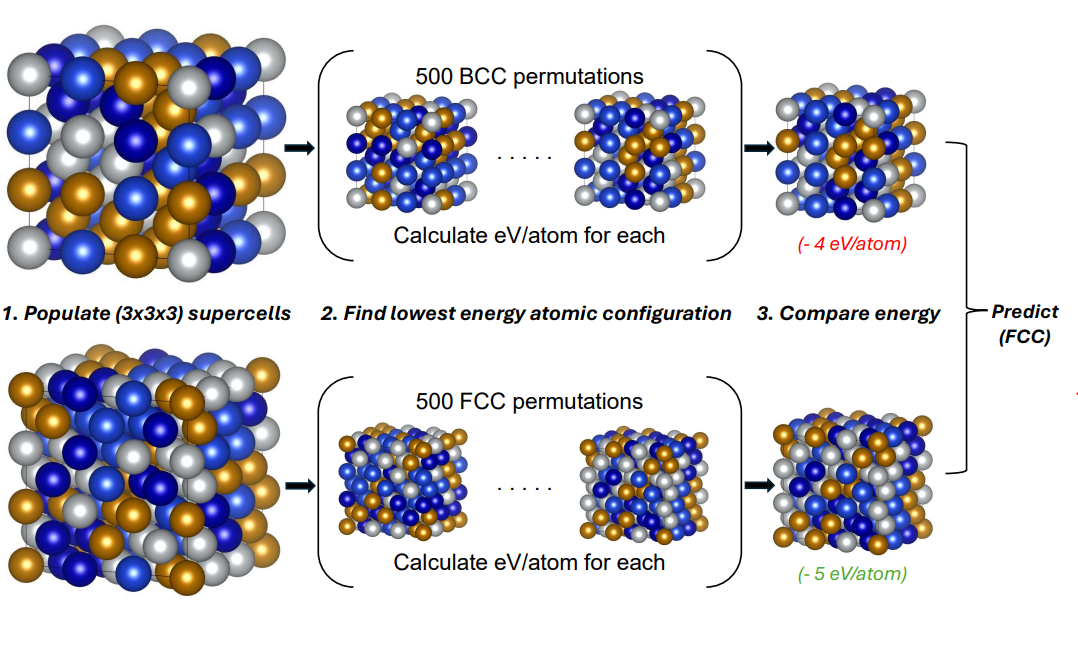

<h4>This is how the method works to make predictions:<h4>

1. Make a supercell with a given HEA composition (alloy, supercell)
2. Randomly shuffle atom positions 500 times and calculate energy (num_structures)
3. Compare the lowest energy structures to make a prediction of the single-phase cubic ground state

Also -- the lattice parameters for the FCC/BCC structures are set to 3.54/3 angstroms respectively, but can be changed if desired. The lattice parameters are taken from literature/what gives higher accuracy in this method.

In [9]:
# This cell is an example of only keeping the best structures

# set all of the parameters for the functions
alloy = 'Al2FeCuNiMn'
supercell = (3,3,3)
num_structures = 100
alloy_string = remove_decimals(alloy)

FCC, FE = find_best_permutation(alloy, 'FCC', 3.54, supercell, num_structures)
BCC, BE = find_best_permutation(alloy, 'BCC', 3, supercell, num_structures)

print(f'FCC lowest energy: {FE}')
print(f'BCC lowest energy: {BE}')

if FE<BE:
  print('prediction: FCC')
else:
  print('prediction: BCC')



Processing FCC Al2FeCuNiMn:   0%|          | 0/100 [00:00<?, ?iteration/s]/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
Processing BCC Al2FeCuNiMn: 100%|██████████| 100/100 [00:12<00:00,  8.31iteration/s]

FCC lowest energy: -2.9115219116210938
BCC lowest energy: -2.9081382751464844
prediction: FCC


In [10]:
# view and rotate the structure to see what the best permutation is
view(FCC, viewer='x3d')

<h4>Additional functionality for analysis:<h4>

1. Return all generated structures and their energies in a dictionary as {energy:structure}
2. Find and keep track of the low, high, and mean energy structures
3. Plot the distributions of energy across the configuration space of FCC/BCC structures

In [11]:
alloy = 'Al2FeCuNiMn'
supercell = (3,3,3)
num_structures = 500
alloy_string = remove_decimals(alloy)


# Random structure search on specified structure, number of permutations
FCC = random_structure_search(alloy, 'FCC', 3.54, supercell, num_structures)

# get list of energies (the keys of dictionary)
FCCenergies=list(FCC.keys())
# lowest energy key
Flow = min(FCC.keys())
# highest energy key
Fhigh = max(FCC.keys())
# get avg of energies
Fmean= statistics.mean(FCC.keys())
# find the key closest to the avg
Fmed = min(FCC, key=lambda x: abs(x - Fmean))

# assign structures (low = FLS, med = FMS, high = FHS) as the values associated with respective keys
FLS = FCC[Flow]
FHS = FCC[Fhigh]
FMS = FCC[Fmed]

# save poscar files
FLS.write(f'low_{alloy_string}_FCC.vasp',  format='vasp')
FMS.write(f'med_{alloy_string}_FCC.vasp', format='vasp')
FHS.write(f'high_{alloy_string}_FCC.vasp', format='vasp')


# do all of the the same for BCC
BCC = random_structure_search(alloy, 'BCC', 3, supercell, num_structures)

BCCenergies=list(BCC.keys())
Blow = min(BCC.keys())
Bhigh = max(BCC.keys())
Bmean= statistics.mean(BCC.keys())
Bmed = min(BCC, key=lambda x: abs(x - Bmean))


BLS = BCC[Blow]
BHS = BCC[Bhigh]
BMS = BCC[Bmed]

write(f'low_{alloy_string}_BCC.vasp', BLS, format='vasp')
write(f'med_{alloy_string}_BCC.vasp', BMS, format='vasp')
write(f'high_{alloy_string}_BCC.vasp', BHS, format='vasp')





Processing BCC Al2FeCuNiMn: 100%|██████████| 500/500 [01:02<00:00,  8.06iteration/s]


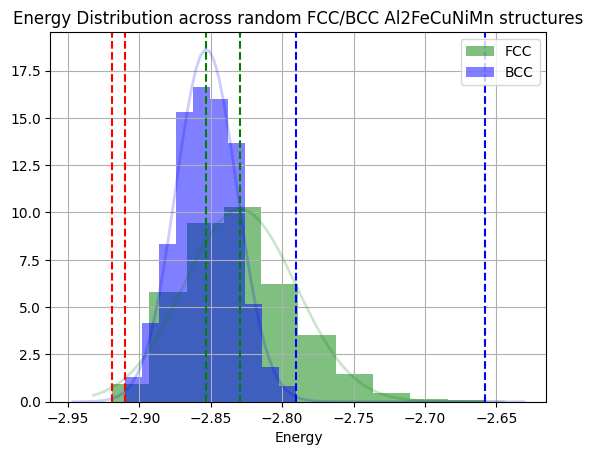

BCC lowest energy: -2.9102394580841064
FCC lowest energy: -2.9190545082092285
prediction: FCC


In [12]:
# plot the energy distributions and low, med, high energies for FCC/BCC on a single plot

%matplotlib inline

distribution(FCCenergies, 'FCC', 'g')
distribution(BCCenergies, 'BCC', 'b')

plt.axvline(x=Flow, color='r', linestyle='--')
plt.axvline(x=Fmed, color='g', linestyle='--')
plt.axvline(x=Fhigh, color='b', linestyle='--')
plt.axvline(x=Blow, color='r', linestyle='--')
plt.axvline(x=Bmed, color='g', linestyle='--')
plt.axvline(x=Bhigh, color='b', linestyle='--')


plt.title(f'Energy Distribution across random FCC/BCC {alloy} structures')
plt.xlabel('Energy')
plt.grid(True)
plt.legend()
plt.show()

print(f'BCC lowest energy: {Blow}')
print(f'FCC lowest energy: {Flow}')

if Blow<Flow:
  print('prediction: BCC')
else:
  print('prediction: FCC')

In [19]:
view(FLS, viewer='x3d')

In [18]:
view(BLS, viewer='x3d')

# Tests on data from the paper

In [13]:
# Get the data from the github repository

!wget https://raw.githubusercontent.com/nicholasjbeaver/HEA-Energy-Sampling/main/LowMedHigh_energy_results.csv
!wget https://raw.githubusercontent.com/nicholasjbeaver/HEA-Energy-Sampling/main/LowMedHigh_energy_structures.zip

--2024-08-06 16:03:22--  https://raw.githubusercontent.com/nicholasjbeaver/HEA-Energy-Sampling/main/LowMedHigh_energy_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2683070 (2.6M) [text/plain]
Saving to: ‘LowMedHigh_energy_results.csv’

LowMedHigh_energy_r 100%[===================>]   2.56M  --.-KB/s    in 0.02s   

2024-08-06 16:03:23 (170 MB/s) - ‘LowMedHigh_energy_results.csv’ saved [2683070/2683070]

--2024-08-06 16:03:23--  https://raw.githubusercontent.com/nicholasjbeaver/HEA-Energy-Sampling/main/LowMedHigh_energy_structures.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 

In [14]:
# load dataset into pandas

df = pd.read_csv('LowMedHigh_energy_results.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    132 non-null    int64  
 1   alloy         132 non-null    object 
 2   Flow          132 non-null    float64
 3   Fmed          132 non-null    float64
 4   Fhigh         132 non-null    float64
 5   FCCenergies   132 non-null    object 
 6   Blow          132 non-null    float64
 7   Bmed          132 non-null    float64
 8   Bhigh         132 non-null    float64
 9   BCCenergies   132 non-null    object 
 10  Experimental  132 non-null    object 
 11  prediction    132 non-null    object 
 12  LSS1          132 non-null    object 
 13  LSS2          132 non-null    object 
 14  LSS3          132 non-null    object 
 15  LSS4          132 non-null    object 
 16  LSS5          132 non-null    object 
dtypes: float64(6), int64(1), object(10)
memory usage: 17.7+ KB


In [15]:
import zipfile
import os

# Path to the downloaded zip file
zip_file_path = '/content/LowMedHigh_energy_structures.zip'

# extract the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()


In [16]:
df['alloy'].head()

0       Al0.25MoNbTiV
1    Al2CoCrFeMo0.5Ni
2            CoCrMnNi
3       Al2.5CoCrFeNi
4     Al0.3CoCrCuFeNi
Name: alloy, dtype: object

In [17]:
alloy = 'Al0.4CrCuFeNi2'
alloy_string = remove_decimals(alloy)
d = 'LowMedHigh_500RSS_unrelaxed'

# read in the low energy structure to ASE atoms
fl = ASEread(f'{d}/low_{alloy_string}_FCC.vasp')
# set the calculator
fl.calc = calc
# get the energy
fle = fl.get_potential_energy()/len(fl.get_atomic_numbers())

# ^do the same for mean, high energy structures
fm = ASEread(f'{d}/med_{alloy_string}_FCC.vasp')
fm.calc = calc
fme = fm.get_potential_energy()/len(fm.get_atomic_numbers())

fh = ASEread(f'{d}/high_{alloy_string}_FCC.vasp')
fh.calc = calc
fhe = fh.get_potential_energy()/len(fh.get_atomic_numbers())

# repeat for BCC structures
bl = ASEread(f'{d}/low_{alloy_string}_BCC.vasp')
bl.calc = calc
ble = bl.get_potential_energy()/len(bl.get_atomic_numbers())

bm = ASEread(f'{d}/med_{alloy_string}_BCC.vasp')
bm.calc = calc
bme = bm.get_potential_energy()/len(bm.get_atomic_numbers())

bh = ASEread(f'{d}/high_{alloy_string}_BCC.vasp')
bh.calc = calc
bhe = bh.get_potential_energy()/len(bh.get_atomic_numbers())

# print all of the energies in order (FCC, BCC)
print(fle, fme, fhe, ble, bme, bhe)

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


-2.6166188716888428 -2.590651750564575 -2.5604207515716553 -2.623263120651245 -2.596104383468628 -2.5595076084136963


In [18]:
# show the dataset for the same alloy to compare
df.loc[df['alloy']==alloy][['alloy','Flow','Fmed','Fhigh','Blow', 'Bmed', 'Bhigh']]

,alloy,Flow,Fmed,Fhigh,Blow,Bmed,Bhigh
95,Al0.4CrCuFeNi2,-2.616619,-2.590652,-2.560421,-2.623263,-2.596105,-2.559507


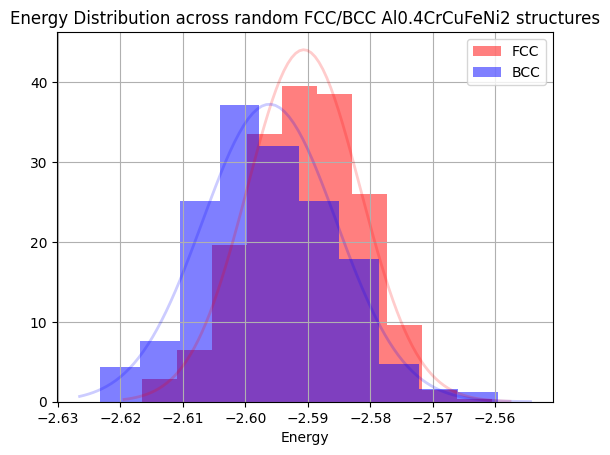

In [19]:
# plot the distributions of FCC/BCC configuration energy for the given alloy

FCC = eval(df.loc[df['alloy'] == alloy, 'FCCenergies'].iloc[0])
BCC = eval(df.loc[df['alloy'] == alloy, 'BCCenergies'].iloc[0])


distribution(FCC, 'FCC', 'r')
distribution(BCC, 'BCC', 'b')

%matplotlib inline

plt.title(f'Energy Distribution across random FCC/BCC {alloy} structures')
plt.xlabel('Energy')
plt.grid(True)
plt.legend()
plt.show()

In [20]:
# view a structure
print(alloy)
view(fl, viewer='x3d')

Al0.4CrCuFeNi2


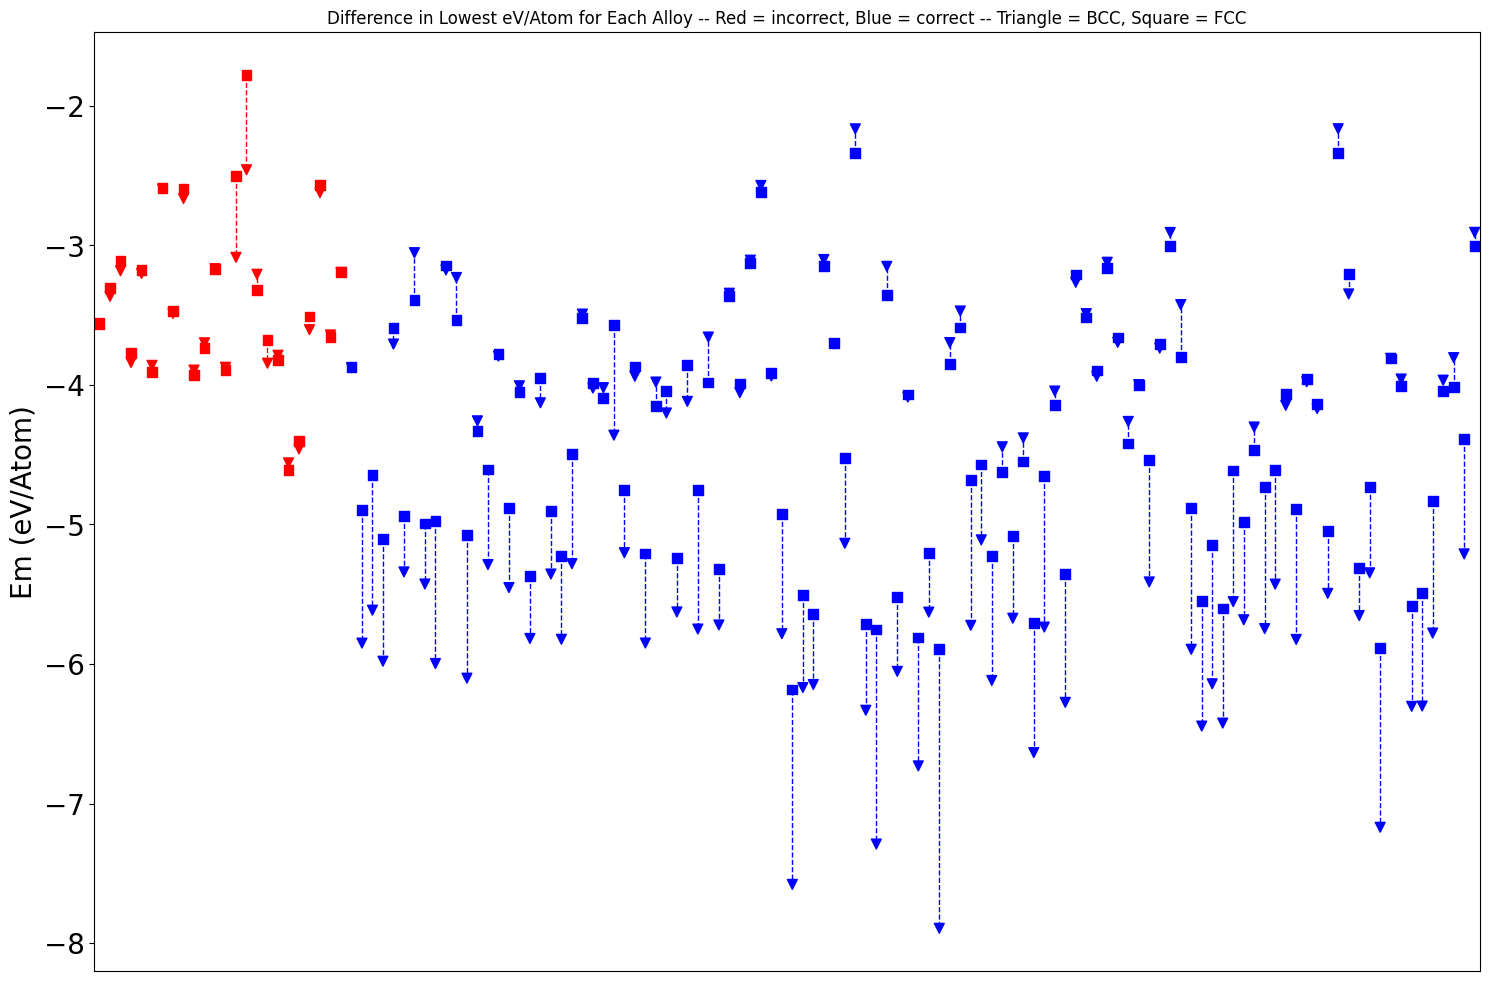

In [23]:
# plot the differences in lowest energy for all of the alloys, and show correct/incorrect predictions

%matplotlib inline
df['correct'] = df['prediction'] == df['Experimental']

df = df.sort_values(by=['correct'])

def bool_color(x):
    return 'blue' if x else 'red'


alloys = list(df['alloy'])
correct = list(df['correct'])
Flow = list(df['Flow'])
Fmed = list(df['Fmed'])
Fhigh = list(df['Fhigh'])
Blow = list(df['Blow'])
Bmed = list(df['Bmed'])
Bhigh = list(df['Bhigh'])

# Calculate the positions for plotting
x = np.arange(len(alloys))

# Plotting
plt.figure(figsize=(15, 10))


plt.scatter(x, Fmed, color=[bool_color(x) for x in df['correct']], s=50, marker='s', label='FCC Mean Energy')
plt.scatter(x, Bmed, color=[bool_color(x) for x in df['correct']], s=50, marker='v', label='BCC Mean Energy')
plt.vlines(x, ymin=Fmed, ymax=Bmed, color=[bool_color(x) for x in df['correct']], alpha=1, linewidth=1,linestyle='--')


# Adjust x-axis limits to remove extra white space
plt.xlim(x[0] - 0.5, x[-1] + 0.5)  # Adding padding to the left and right of the plot


# Customizing labels and title
plt.xticks(x, correct, rotation=90, fontsize=6)
plt.yticks(fontsize=20)
plt.ylabel('Em (eV/Atom)', fontsize=20)


# Show plot
plt.tight_layout()
plt.xticks([], [])
plt.title('Difference in Lowest eV/Atom for Each Alloy -- Red = incorrect, Blue = correct -- Triangle = BCC, Square = FCC')

plt.show()
